<a href="https://colab.research.google.com/github/talhavawda/tic-tac-toe-monte-carlo/blob/master/TicTacToe_MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tic Tac Toe decision-making using Monte Carlo Tree Search

 ## COMP703 (Artificial Intelligence) 2021 Assignment 1
 
 Team: A1GroupWC

 Team Members:
 -  Azhar Mohamed&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;(218006491)
 - Yashlin Naidu &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;(216019492)
 - Ricardo Pillay &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;(218009114)
 - Ahmad Jawaad Shah&ensp;&ensp;&ensp;(218029400)
 - Talha Vawda &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;(218023210)

<br>

## Acknowledgements and References
1. Russell SJ, Norvig P. Artificial Intelligence: A Modern Approach. 4th ed. Upper Saddle River: Prentice-Hall; 2020.
2. Kocsis L, Szepesvári C, Willemson J. Improved Monte-Carlo Search. 2006; Available from: https://www.semanticscholar.org/paper/Improved-Monte-Carlo-Search-Kocsis-Szepesvari/b2c20a877a891ea97179658c06a6d552b50cba6e
3. Browne CB, Powley E, Whitehouse D, Lucas SM, Cowling PI, Rohlfshagen P, et al. A Survey of Monte Carlo Tree Search Methods. IEEE Transactions on Computational Intelligence and AI in Games [Internet]. 2012 Mar;4(1):1–43. Available from: https://ieeexplore.ieee.org/abstract/document/6145622
4. Python. PEP 8 -- Style Guide for Python Code [Internet]. Python.org. 2001 [cited 2021 Sep 15]. Available from: https://www.python.org/dev/peps/pep-0008
5. Stack Overflow. python - How do I check if a list is empty? [Internet]. Stack Overflow. 2008 [cited 2021 Sep 15]. Available from: https://stackoverflow.com/questions/53513/how-do-i-check-if-a-list-is-empty


We declare that this entire implementation has been designed and developed by ourselves.   



---



# Introduction and Background
Our variant on Tic Tac Toe is one that is aimed to make the game more interesting. The original game involves of lining up 3 of the same type of token (X or O) on a row, column or diagonal, in a 3 by 3 grid in order to win. There are 3 types of tokens that are used in our variant: "X","Y" and "S". The X and Y tokens are the player tokens (to be used by each of the 2 players) while the S tokens are universal tokens that are placed randomly on the board before the game commences. The S token may be used by either player as a their own in order to allow themselves to win the game faster. Measures have been taken to prevent the S tokens from giving an unfair advantage to 1 player. These include: not allowing S tokens to be placed in the same row and column, and also ensuring no to S tokens will be more less than 2 spaces away from each other on the diagonals. Our variant allows the game to played on the following square grid sizes: 4 by 4, 5 by 5, 6 by 6 and 7 by 7. Furthermore for a 4 by 4 grid you are only required to line up 3 of the same tokens on a row, column or diagonal to win. Similary, for a 5 by 5 and 6 by 6 grid, you are only required to line up 4 tokens and with a 7 by 7, you must line up 5 tokens to win. The tokens one lines up to win may consist of only 1 type of player token (X or Y) or 1 type of player token and an S token.


# Implementation

Please run all code cells in order (on your first run) so that classes that  are used later on are 'compiled' and are accessible/existing before they are used.


## Imports and constants
This cell contains all the libraries that is needed to run this game.
 Furthermore, constant initializations are done here and will be used throughout the notebook.

In [ ]:
"""
    Imports
"""
import numpy as np
import math
import copy
import random


"""
    Constants

    The constant C in the UCT formula:
        We have used the theoretical optimal value of C is (sqrt(2) [1.414]). 
        We have experimented with our values but sqrt(2) appears to also be the
        optimal value for our practical implementation that balances 
        Exploration and Exploitation ensuring the best move to make is returned
        by every run of the MCTS algorithm
        This constant will be used by Node.calculate_uct_value()
"""
C = math.sqrt(2)

## State class

This class is used to represent a specific State of our Tic Tac Toe game variant, i.e. a game board with neutral and player tokens placed on it, the player (X or O) whose turn it is to play next on this board, and the move that was played by the opposite player on the previous board (of the previous game State) to result in this board. A move on a State results in a new State of the game with the turn now being passed onto the other player.

A game board itself is represented using a 2D array of integer values, with each element in the array representing a square on the board. These integer values represent the token placed on the square or whether the square is empty.

The move field of this class will be used by the MCTS algorithm to determine the best move for the current player to make on the current state of the game. 



In [ ]:
class State:
    """
        A Tic Tac Toe state for the Monte Carlo Tree Search Algorithm
        
        A State of the game is a specific board scenario, along with the player 
        whose turn it is to play next, and the move that was played on the 
        previous state to result in this state

    """


    def __init__(self, board=None, turn=None, move=None):
        """
            Constructor for the initial creation of a Tic Tac Toe State.

            :param move: the move (a 2-tuple indicating the square) that was
            performed on the previous state to reach this state by the opposite 
            player (the opposite player is -turn)
        """

        if board != None:
            # Create a board for an existing game state
            self.board = board
        else:
            # Create the board for the initial game state
            self.board = TicTacToeGame.initial_game_board()
            self.turn = TicTacToeGame.X # this variable represents the player whose turn it is to play on this current state (current player) | X plays first on an initial board

        if turn != None:
            self.turn = turn # The player whose turn it is to currently play on this current state, either TicTacToeGame.X or TicTacToeGame.O
        else:
            #Determine whose turn it is by counting the number of X's and O's on the board. if X's==O's then X's turn otherwise O's
            num_x = (np.array(self.board) == TicTacToeGame.X).sum()
            num_y = (np.array(self.board) == TicTacToeGame.O).sum()
            if num_x > num_y:
              self.turn = TicTacToeGame.O
            else:
              self.turn = TicTacToeGame.X


        self.move = move

        
    def toggle_turn(self, turn):
        """
            Alternate:
            if turn == TicTacToeGame.X:
                return TicTacToeGame.O
             else:
                return = TicTacToeGame.O
        """

        return -turn # since TicTacToeGame.X == -TicTacToeGame.O and vice versa


    def turn_to_string(self):
        if self.turn == TicTacToeGame.X:
            return "X"
        else:
            return "O"
        

## TicTacToeGame class

Since a Tic Tac Toe game consists of a multitude of possible States, we have a class to represent an instance of a game itself - this TicTacToeGame class.

An instance of this class represents a Tic Tac Toe game that is being played. This game is of our Tic Tac Toe variant and thus has its own dimensions, which is passed in as a parameter to the constructor, which then determines the number of tokens needed in a row to win, and also the number of neutral tokens that need to be randomly placed on the board (within certain constraints) before the game starts.

This class defines constants that are used for the Tic Tac Toe game: 
These are of integer types, which represent the board tokens (X, O, S, EMPTY), and the game conditions (IN_PROGRESS, DRAW, WIN). The X and O constants also refer to the players themselves (whose turn it is to play) in addition to being tokens on the game board, as well as for specifying the WIN game condition (a win is represented by either X or O), and the utilty value of a terminal state (a state where the game has reached completetion - a draw or a win has been achieved). This makes it easy to determine the winner and calculte the utilty value of a terminal state. Furthermore,  X and O being 1 and -1 respectively makes it trivial to get the player whose turn it is of the resulting state when applying a move tho the current state, as we just have to negate the current state’s turn field. 

We have also defined MAX and MIN players (which are X and O respectively as X plays first) which shall be called by the Monte Carlo Tree Search function to dettermine the best move the current player should make.


In [ ]:
class TicTacToeGame:
    """ 
        A class that represents our variant of the Tic Tac Toe game
        The purpose is to initialise a Tic Tac Toe game by creating a nxn square board
        and placing the neutral tokens on it, and to hold the n, k, and neutral_tokens values


        The board is being implemented as a nxn array with an index pair representing
        a square on the board and the element values being either  2, 1, -1, 0 
        to represent a neutral token, the X token, the O token, and an empty square (where
        no token has been played yet)

        We are having a specific game class as we are demonstrating various examples of Tic Tac Toe game scenarios
        where different games could have a different size board, so we're going to need different game instances
        representing different games with their boards to pass into the MCTS algorithm

        An instance of this class (representing a game scenario) will be passed into the Monte Carlo Tree Search (MCTS) algorithm
    """

    # Constants for a Tic Tac Toe game

    X = 1  # Player/Token X
    EMPTY = 0  # An empty square (no tokens placed on it yet)
    O = -1  # Player/Token O
    S = 2  # Neutral Token
    
    IN_PROGRESS = 3  # Game in progress
    DRAW = 4  # Game over and game ended in draw
    # WIN is represented by X and O constants

    # MCTS uses Max and Min players
    MAX = X # Player Max is the X token (as X plays first)
    MIN = O


    def __init__(self, n):
        """
            :param n: Dimensions of the board - Since the board is a square board, the board will be an nxn board

            k is the number of tokens needed in a row to win
            neutral_tokens is the number of neutral tokens ('S') that the board will contain
        """
        self.n = n
        
        self.k, self.neutral_tokens = self.get_k_and_nt(n)


       

    def get_k_and_nt(self,n):
        """
           determines the k value and number of neutral tokens based on the size of the board specified by the user.

           :return: a 1-D tuple of size 2 with k being the first element and neutral_tokens being the second element
        """

        k = 0
        neutral_tokens = 0

        if n == 4:
            k = 3
            neutral_tokens = 1
        elif n in [5, 6]:
            k = 4
            neutral_tokens = 2
        elif n == 7:
            k = 5
            neutral_tokens = 3
        else:
            pass  # We've already covered all cases and validation of n will be done when getting input from the user
        
        return k, neutral_tokens



    def check_in_diagonal(self, board, row, col):
        """
            Check if there is at least 2 cells between every S token on a diagonal

            :return: True if so else False 
        """
        temp_board = [[0 for i in range(self.n + 4)] for j in range(self.n + 4)]

        for i in range(self.n):
            for j in range(self.n):
                temp_board[i + 2][j + 2] = board[i][j]

        if (temp_board[row - 2 + 2][col - 2 + 2] == self.S or temp_board[row - 1 + 2][col - 1 + 2] == self.S or
                temp_board[row + 2 + 2][col + 2 + 2] == self.S or temp_board[row + 1 + 2][col + 1 + 2] == self.S or
                temp_board[row + 2 + 2][col - 2 + 2] == self.S or temp_board[row + 1 + 2][col - 1 + 2] == self.S or
                temp_board[row - 2 + 2][col + 2 + 2] == self.S or temp_board[row - 1 + 2][col + 1 + 2] == self.S):
            return True

        else:
            return False



    def initial_game_board(self):
        """
            Generate an initial board for the game with the neutral tokens (randomly) placed
            on it, and return it.
            No neutral token may be in the same row, column, or within 2 
            squares on the same diagonal as any other neutral tokens

            :return: An initial board of the game (the initial game state) as a 2D array
        """
        board = [[self.EMPTY for i in range(self.n)] for j in range(self.n)]  # initialise a nxn board using Python List Comprehension

        neutral_rows = []
        neutral_cols = []
        rand_row = 0
        rand_col = 0

        for m in range(self.neutral_tokens):
            randRow = random.randint(0, self.n - 1)  # For randint(a, b) both bounds are inclusive i.e. range is [a, b]
            randCol = random.randint(0, self.n - 1)

            # While the coordinates of this square is not valid for a neutral token, generate new coordinates
            # The condition of the while loop also checks if the current square position already has a neutral token placed on it
            while (self.check_in_diagonal(board, rand_row, rand_col) or (rand_row in neutral_rows) or (rand_col in neutral_cols)):
                rand_row = random.randint(0, self.n - 1)
                rand_col = random.randint(0, self.n - 1)

            board[rand_row][rand_col] =  self.S
            neutral_rows.append(rand_row)
            neutral_cols.append(rand_col)
        
        return board



    def create_game_state(self, neutral_moves=None, players_moves=None):
        """
            Create a game situation based on the actions given

            :neutral_moves: a list of the squares on the board that the neutral tokens are placed on - each element
                is a tuple of size 2 indicating the position of the square.  the length of this list must be equal to self.neutral_tokens.
                If None then call self.initial_game_board() to randomly place the neutral tokens
            :players_moves: moves that have already been played by both players - a list of tuples. Each tuple is of size 3.
                For each tuple, the first element is the player whose turn it is (either X or Y), second element is the x coordinate of the square,
                and the third element is the y coordinate. Ensure the coordinates are valid board positions
            :return: a State of the game with its board populated with the specified actions/moved
        """

        turn = self.X # Default - X plays first


        if neutral_moves == None:
            board = self.initial_game_board()
        else:
            board = [[self.EMPTY for i in range(self.n)] for j in range(self.n)]  # initialise a nxn board using Python List Comprehension

            # Add neutral moves from neutral_moves
            for i in range(len(neutral_moves)):
                board[neutral_moves[i][0]][neutral_moves[i][1]] = self.S  # neutral_moves[i][0] is x-coordinate of that tuple and neutral_moves[i][1] is y-coordinate of that tuple

        # Add the moves of the players
        last_move = None
        if players_moves != None:
            for move in players_moves: # Each move is a 3-tuple   
                player, x_coord, y_coord = move
                board[x_coord][y_coord] = player
                last_move = move

            """code to determine the player whose turn it is to play next on this current state"""
            num_x = (np.array(board) == self.X).sum()
            num_y = (np.array(board) == self.O).sum()

            if num_x > num_y:
                turn = self.O
            else:
                turn = self.X

        return State(board, turn, move=last_move)


    def moves(self, state):
        """
            Determine all the actions/moves (x,y pairs) that can be played on the current board state
            and return them

            A move is an empty square that the current player can place their token on
            (It doesn't matter who the current player is)

            :return: a list of tuples, with each tuple being the position/coordinates of a square on the board
        """

        board = state.board

        # A list of tuples
        moves = list()
        board = state.board

        for i in range(len(board)):
            for j in range(len(board[i])):
                # Check if the cell is empty
                if board[i][j] == self.EMPTY:
                    # Create a tuple holding a possible i, j move
                    move_tuple = (i, j)
                    # Add the tuple to the list
                    moves.append(move_tuple)

        return moves


    def play_move(self, state, move):
        """
            Play the specified action/move on this current state (resulting in a child state)
            :return: a new State with the move having being played on it
        """
        # Assumption: move is a tuple
        # Play the move on this state
        board = state.board
        child_board = copy.deepcopy(board)
        child_board[move[0]][move[1]] = state.turn

        # Return a new state - updated board - updated turn
        return State(board=child_board, turn=-state.turn, move=move)  # turn=-self.turn since TicTacToeGame.X == -TicTacToeGame.O and vice versa


    def get_child_states(self, state):
        """
            Generate and return all child states of this state with the current player being state.turn

            Use this method for expansion

            :return: a list of all child States of this state
        """

        child_moves = self.moves(state)
        board = state.board
        child_states = list()

        for move in child_moves:  # move is a tuple represeting the position/coordinates of a square on the board
            child_board = copy.deepcopy(board)
            i = move[0]
            j = move[1]
            child_board[i][j] = state.turn
            child_states.append(State(board=child_board, turn=-state.turn, move=move))  # toggle/switch the current player


        return child_states


    def get_empty_squares(self, state):
        """
            :return: a list of tuples, with each tuple representing the coordinates of an empty square on the board
        """

        board = state.board
        empty_squares = list()

        for i in range(len(board)):
            for j in range(len(board[i])):
                if state.board[i][j] == self.EMPTY:
                    empty_square = (i, j)  # (i, j) is a tuple
                    empty_squares.append(empty_square)

        return empty_squares


    def display_state(self, state):
        """
            Display the state's board to the console
        """

        board = state.board
        output = "   "
        for k in range(len(board)):
            output = output + str(k) + " "
        print(output)
        
        for i in range(len(board)):
            line = str(i)+" "
            for j in range(len(board[i])):
                character = board[i][j]
                if character == self.EMPTY:
                    character = '_'
                elif character == self.X:
                    character = 'X'
                elif character == self.O:
                    character = 'O'
                else:
                    character = 'S'
                line += "|" + str(character)
            line += "|"
            print(line)


    def check_game_over(self, state):
        """
            Determines whether the game is over or not for this state and 
            returns whether the game is over or not, the winner (or lack of one)
            and the utilty (score/value) of this (terminal) state

            The game is over if either X won, O won, or game is a draw
            If the game is over, then this state is a terminal state

            Utility value is 1 if X won, -1 if O won, 0.5 if there is a draw, 
            or 0 if this state is not a terminal state (the game is currently in progress)

            :return: a (is_terminal_state, winner, utilty) tuple 
        """

        # Default - game is not over - currently in progress 
        is_terminal_state = False
        winner = self.IN_PROGRESS 
        utility = 0


        if self.check_k_win(state):
            # If either player has won
            is_terminal_state = True
            winner = -state.turn # The winner is the player who made the move to reach this current state
            utility = winner      # TicTacToeGame.X is represented by 1 and TicTacToeGame.O is represented by -1 so the corresponding value for the winner will be returned

        elif not self.moves(state): 
            # Alternate elif condition: np.array(self.board == self.EMPTY)).sum() == 0
            """
                If the game is a draw:
                If no more moves can be made of the board (if the list returned
                by moves() is empty) i.e. all squares have been filled with tokens
            """
            is_terminal_state = True
            winner = self.DRAW
            utility = 0.5
        else:
            pass # Default values will remain


        return is_terminal_state, winner, utility


    
    def check_k_win(self,state):
        """
            Determines if a state is a win state or not. m is based on the size of k and is used
            to produce a padded matrix tempMatrix, that has m layers of empty spaces/ or 0's around the state board matrix.
            Produces a tempMatrix which is the state board, but it is padded with a layer of zeros
            or empty spaces. This method loops through the entire state board and
            checks each row, column and positive diagonal and negative diagonal (using auxillary functions) for k tokens of the same type including or excluding
            an S token.

            :return: true if win state, else return false
        """
        stateBoard = state.board
         

        m = math.ceil(self.k / 2)
        tempMatrix = [[0 for i in range(self.n + (m * 2))] for j in range(self.n + (m * 2))]
        for i in range(self.n):
            for j in range(self.n):
                tempMatrix[i + m][j + m] = stateBoard[i][j]
        
        for i in range(len(state.board)):
            for j in range(len(state.board[i])):
                if (self.check_vertical_k_win(tempMatrix,state.board, i, j, -state.turn, m) or self.check_horizontal_k_win(tempMatrix,state.board, i, j, -state.turn, m) 
                or self.check_negative_diagonal_k_win(tempMatrix,state.board, i, j, -state.turn, m) or self.check_positive_diagonal_k_win(tempMatrix,state.board, i, j, -state.turn, m)):
                    return True
        return False

   
    def check_vertical_k_win(self,tempMatrix ,matrix, row, col, token, n):
        """
            Given the board co-ordinate (row, col), it counts vertically for consecutive k tokens of the same type on the padded board matrix - tempMatrix, 
            including or excluding an S token. sArray is an array that consists of all the tokens
            found on the vertical. count is the number of consecutive vertical tokens in a column and countS is used the case where S is the first token in a sequence
            and counts the number of consecutive tokens only if the same token is repeated after S.

            :return: true if k tokens found consecutively in a column from co-ordinate (row, col), else return false
        """
        count = 0
        countS = 0
        sArray = []
        sArray.append(token)
        
        rows = self.n
        cols = self.n
        k = self.k

        if row <= rows-2:
            for l in range(k):
            
                    if ((tempMatrix[row + n + l][col + n] == token) or (tempMatrix[row + n + l][col + n] == TicTacToeGame.S)):
                        count = count + 1
                    elif (token == TicTacToeGame.S):
                        if (len(sArray) == 1):
                            sArray.append(tempMatrix[row + n + l][col + n])
                        if (tempMatrix[row + n + l][col + n] in sArray):
                            countS = countS + 1
                        else:
                            countS = 0
                

        if (count == k or countS == k):
                return True
        return False


    def check_horizontal_k_win(self,tempMatrix ,matrix, row, col, token,n):
        """
            Given the board co-ordinate (row, col), it counts horizontally for consecutive k tokens of the same type on the padded board matrix - tempMatrix, 
            including or excluding an S token. sArray is an array that consists of all the tokens
            found on the horizontal. count is the number of consecutive horizontal tokens in a row and countS is used the case where S is the first token in a sequence
            and counts the number of consecutive tokens only if the same token is repeated after S.


            :return: true if k tokens found consecutively in a row from co-ordinate (row, col), else return false
        """
        count = 0
        countS = 0
        sArray = []
        sArray.append(token)

        rows = self.n
        cols = self.n
        k = self.k
 
        if col <= cols-2:
           
                for l in range(k):
                    if ((tempMatrix[row + n][col + n + l] == token) or (tempMatrix[row + n][col + n + l] == TicTacToeGame.S)):
                        count = count + 1
                    elif (token == TicTacToeGame.S):
                        if (len(sArray) == 1):
                            sArray.append(tempMatrix[row + n][col + n + l])
                        if (tempMatrix[row + n][col + n + l] in sArray):
                            countS = countS + 1
                        else:
                            countS = 0
            

        if (count == k or countS == k):
                    return True
        return False


    def check_negative_diagonal_k_win(self,tempMatrix ,matrix, row, col, token, n):
        """
            Given the board co-ordinate (row, col), it counts the negative diagonal for consecutive k tokens of the same type on the padded board matrix - tempMatrix, 
            including or excluding an S token. sArray is an array that consists of all the tokens
            found on the negative diagonal. count is the number of consecutive negative diagonal tokens and countS is used the case where S is the first token in a sequence
            and counts the number of consecutive tokens only if the same token is repeated after S or is S.

            :return: true if k tokens found consecutively in the negative diagonal from co-ordinate (row, col), else return false
        """
        count = 0
        countS = 0
        sArray = []
        sArray.append(token)

        rows = self.n
        cols = self.n
        k = self.k

        if row <= rows - 2 and col <= cols-2:
            for l in range(k):
               
                    if ((tempMatrix[row + n + l][col + n + l] == token) or (tempMatrix[row + n + l][col + n + l] == TicTacToeGame.S)):
                        count = count + 1
                    elif (token == TicTacToeGame.S):
                        if (len(sArray) == 1):
                            sArray.append(tempMatrix[row + n + l][col + n + l])
                        if (tempMatrix[row + n + l][col + n + l] in sArray):
                            countS = countS + 1
                        else:
                            countS = 0
                

        if (count == k or countS == k):
                    return True
        return False


    def check_positive_diagonal_k_win(self,tempMatrix ,matrix, row, col, token, n):
        """
            Given the board co-ordinate (row, col), it counts the positive diagonal consecutive for k tokens of the same type on the padded board matrix - tempMatrix, 
            including or excluding an S token. sArray is an array that consists of all the tokens
            found on the negative diagonal. count is the number of consecutive positive diagonal tokens and countS is used the case where S is the first token in a sequence
            and counts the number of consecutive tokens only if the same token is repeated after S or is S.


            :return: true if k tokens found consecutively in the positive diagonal from co-ordinate (row, col), else return false
        """
        count = 0
        countS = 0
        sArray = []
        sArray.append(token)

        rows = self.n
        cols = self.n
        k = self.k

        if row <= rows - 2 and col <= cols-2:
            for l in range(k):
                
                    if ((tempMatrix[row + n - l][col + n + l] == token) or (tempMatrix[row + n - l][col + n + l] == TicTacToeGame.S)):
                        count = count + 1
                    elif (token == TicTacToeGame.S):
                        if (len(sArray) == 1):
                            sArray.append(tempMatrix[row + n - l][col + n + l])
                        if (tempMatrix[row + n - l][col + n + l] in sArray):
                            countS = countS + 1
                        else:
                            countS = 0
                

        if (count == k or countS == k):
                    return True
        
        return False





## Node Class

[The root node of the tree is the current game state on which we want to decide the best move to make]


Node class for adversarial game: 

Option 1 (this is what sir mentions in notes): have 2 separate win counters, one for player 1 (Max) and one for player 2 (Min) and the one that is used to calculate UCT value is the player who's turn it is to currently play (Me: in state 0 - the initial state of the algo - the current state of the game). So if terminal value is positive then increment Player 1's score, else if negative then increment Player 2's score with the absolutve value of the terminal value. (We can also increment both players' scores (with half the value of a win - if win=1 then draw =0.5 for both players) if there is a draw). 
[AIMA mentions about having a vector of values per node for multiplayer games]

Option 2: have 1 score value, higher value indiciating preference to Max and lower value indicating preference to Min (thus value can go negative). So algo selects the node with either the best or worst UCT value depending on who's turn it is

Option 3 (See: https://en.wikipedia.org/wiki/Monte_Carlo_tree_search#Principle_of_operation): have 1 score/value counter for each node, and that score reperesents the player that that node represents. So when backpropagating, we update every alternate ascendant node with the score (the start of the alternation depends on whether the leaf node that was rolled out resulted in a win/loss for the player that that lead node represents). (So if selecting a child node, then the current node will have to choose the child with the minimum value as the values of the children represent that of the opposite player)
[This option is similar to Option 1]


Going with Option 1

Modelling: use MaxV and MinV for the scores of the 2 players in the Node representation. Max is the X token (the player who plays the first move of the game) and Min is the O token


calculate_uct_value_() explanation (also see its docstring):

in select_best__child() for the current node, we calculating the uct of each of its child nodes and selecting the one that has the highest uct value.
But the node that has the highest uct value needs to be in terms of this node - the player of this current node's state whose turn it is to make a move. cos we want to select the best move that this current player should play.

So when calculating the child node that has the highest uct value, it needs to be in terms of the player of this current node.

say the current node is X's turn to play. we want to select a child node of X (all of which are O's turn to play) that is the best move for x - so we want to get the node that has the max wins for X in the rollouts

all of the child nodes are O's turns. so when calcuating uct of the child node, we use the player of the parent node, which is X. and vice versa if current node is O's turn to play


In [ ]:
class Node:
    """
        A node for the Monte Carlo Tree Search algorithm, that is based on 
        a Tic Tac Toe State
     """
 
 
    def __init__(self, state: State, parent=None):
        """
            Constructor for the Node class

            Parameters:
            :param state (State): An instance of the state of the game
            :param parent (Node): The parent node of the current node
        """

        # The number of wins for player Max through this node
        self.Max_V = 0

        # The number of wins for player Min through this node
        self.Min_V = 0

        # The number of times the node (or its children) has been rolled out
        self.n = 0

        # The parent Node
        self.parent = parent

        # The Game State
        self.state = state

        # Chilren Nodes
        self.children = list()
    

    def calculate_uct_value(self):
        """
            Calculate and return the UCT value of this node based on the player whose turn it is 
            in the state of the parent node of this node

            We are using the player of the parent node's state instead of the player
            of this node's state as this node's state is a result of the player
            of the parent node's state making a move, and the UCT value will be used
            to determine the quality of the move from the parent nodes perspective.

        
            :return: uct: Float
        """

       
        if self.n == 0:  # Check for 0 division
            # Return positive infinity (This node must be set to a high priority for Exploration)
            return np.inf
        else:
            v = 0

            parent_turn = -self.state.turn # Get the player whose turn it was in the State of the parent node of this node

            """ 
                Alternatively we could've used self.parent.state.turn instead of calculating
                parent_turn. However the root node of the tree doesn't have a parent node so calling
                this function on it will give an error. So toggling the turn
                is doing some validation checking in case calculate_uct_value() is ever
                called on the parent node (although in our MCTS algorithm, that won't happen, as 
                the UCT value calculation is only called on children nodes of a node) - the
                turn of the previous state of the parent node (current state of the game) will be used
                as Tic Tac Toe has 2 players who alternate on every move. 
            """
            if parent_turn == TicTacToeGame.X:
                v = self.Max_V # Player Max is X
            else:
                v = self.Min_V # Player Min is Y


            # Return uct value for this node (based on its parent node's state's current player)
            return (v/self.n) + C * math.sqrt(np.log(self.parent.n)/self.n)


    def select_best_child(self):
        """
            Determine the best child node of this node

            :return: best_child: Node
        """
        max_uct = -math.inf # Initialise to lowest possible number
        best_child = None
        for child in self.children:
            uct_value = child.calculate_uct_value()
            if uct_value > max_uct:
                max_uct = uct_value
                best_child = child
        return best_child


    def to_string(self):
        output = "Node Summary\nNumber of wins through this node: {}\nNumber of visits: {}\nUCT value = {}".format(self.v, self.n, self.calculate_uct_value())
        return output

## Monte Carlo Tree Search

AIMA: When the iterations terminate, the move with the highest number of Playouts/Rollouts is returned. You might think that it would be better to return the node with the highest average utility, but the idea is that a node with 65/100 wins is better than one with 2/3 wins, because the latter has a lot of uncertainty. In any event, the UCB1 formula ensures that the node with the most playouts is almost always the node with the highest win percentage, because the selection process favors win percentage more and more as the number of playouts goes up.


At the end, number of rollouts on the root node = number of iterations,
as for each iteration, the result propagates back to the root node


In [ ]:
def monte_carlo_tree_search(game, state, iterations=100):
    """
        Conduct the MCTS from the given state (the state that is passed in)
        Return the best move to make on the state passed in (the current state of the game)
        along with its resulting state
    """

    # Child/Sub Functions

    def add_child_nodes(node):
        """
            Create children nodes of this node and add it to the node as its children
        """

        state = node.state
        child_states = game.get_child_states(state)
        node.children = list() # initialise to an empty list
        
        if child_states: # if the child_states list is not empty
            for child_state in child_states:
                node.children.append(Node(child_state, parent=node)) # add child state as a child node to this current node


    def random_move(state):
        """
            Randomly select an action/move from all the possible moves that
            can be made on this state and return it

            :returns: random_move: A tuple (i, j) to place a move
        """

        possible_moves = game.moves(state)
        option = random.randint(0, len(possible_moves)-1)
        random_move = possible_moves[option]
        return random_move


    def simulate(state, move):
        """
            Apply a random action on the state

            Return:
            new_state: State
        """

        new_state = game.play_move(state, move)
        return new_state


    def rollout(state):

        while True:
            
            is_terminal_state, winner, utility = game.check_game_over(state)
            
            if is_terminal_state:
                return winner, utility

            action = random_move(state)
            state = simulate(state, action)


    def backpropagate(node, winner, result):
        """
            :param node: the node that rollout was done on and to start backpropagating
                the result from
            :param winner: the winner value returned by check_game_over()
            :param result: the utility value returned by check_game_over()
        """

        while node.parent != None:
            
            node.n += 1

            if winner == game.DRAW:
                node.Max_V += result
                node.Min_V += result
            elif winner == game.MAX:
                node.Max_V += result
            else: # if winner == game.MIN
                node.Min_V += result

            node = node.parent

        # Do for root node (parent==None)
        node.n += 1

        if winner == game.DRAW:
            node.Max_V += result
            node.Min_V += result
        elif winner == game.MAX:
            node.Max_V += result
        else: # if winner == game.MIN
            node.Min_V += result


    root_node = Node(state)
    count = 0
  
    while count < iterations:
        #print("Iteration:", count+1)
        current = root_node # reset current for this new iteration - point back to the root node of the tree

        """
            While current is not a leaf node (has children nodes), get the best child of current.
            Stop when current is a leaf node (doesn't have any children)

            current.children will evaluate to true if the children list is
            not empty (current has children nodes), and will evaluate to false
            if the children list is empty (current doesn't have any children
            nodes -> current is a leaf node)

        """

        # Tree Traversal: while current is not a leaf node
        #current.children will evaulate to True if the children list is not empty else False
        while current and current.children: 
            #print(game.display_state(current.state))
            current = current.select_best_child()

        # current is now a leaf node (doesn't have any children)
        is_terminal_state, winner, utility = game.check_game_over(current.state)
        
        # if the state of the current node is a terminal state, then return its utilty (already calculated above)
        # if current.n == 0  then its utility will be returned anyway in rollout()
        # but if current.n != 0 there will be an issue as this node will not have any child nodes
        # and we'll be accessing the first child node of this node
        if not is_terminal_state: # if the state of the current (leaf) node is not a terminal state 
            if current.n == 0:
                winner, utility = rollout(current.state)
            else:
                add_child_nodes(current)
                #current = current.select_best_child()
                current = current.children[0] # First new child node
                winner, utility = rollout(current.state)
        backpropagate(current, winner, utility)
        count = count + 1

    # Return best action/move to make
    # AIMA: When the iterations terminate, the move with the highest number of Playouts/Rollouts is returned
    max_rollouts = 0
    best_move = None
    resultant_state = None

    rollouts_children_string = "Number of rollouts on chidren of root node (representing current state of the game):\n\t"
    for child in root_node.children:
        rollouts = child.n
        rollouts_children_string += str(rollouts) + ", "
        if rollouts > max_rollouts:
            max_rollouts = rollouts
            best_move = child.state.move
            #print(best_move.state.board)
            resultant_state = child.state
    
    rollouts_children_string += "\n"
    print(rollouts_children_string)

    return best_move, resultant_state, max_rollouts







# Examples
The following examples will demonstrate our implementation of the Monte Carlo Tree Search(MCTS) algorithm on our variant of the Tic Tac Toe game. Each example contains an initial state and displays the next best state for the player.



In [ ]:
# For ease of access by the examples below
X = TicTacToeGame.X
O = TicTacToeGame.O

 
def get_num_iterations(game):
    """
        Number of iterations that the MCTS algorithm should perform based on the game.
        The larger the board, the more iterations needed as the number of possible state
        permutations increases exponentially:
            n = 4: board size = 16 & permutations = 16! = 2.09x10^13
            n = 5: board size = 25 & permutations = 25! = 1.55x10^25
            n = 6: board size = 36 & permutations = 36! = 3.72x10^41
            n = 7: board size = 49 & permutations = 49! = 6.08x10^62

        For out Tic Tac Toe variant game, the number of iterations will be as follows:
        4x4 board = 6000 iterations 
        5x5 board = 10000 iterations
        6x6 board = 24500 iterations
        7x7 board = 32000 iterations
    """
    if game.n in [4, 5]:
        return game.n * (game.n-1) * 500
    else:
        return (game.n+1) * (game.n+1) * 500
            

## Example 1: 4x4 Ex 1
This example features a 4x4 board on which, one neutral token, two X tokens and one O token has been placed. It is O's turn to play. Looking at the current game state, there are not many decisve moves that can be made, however; O should play a move that will positively impact its winning chnaces in the long run.

In [ ]:
game = TicTacToeGame(4)
current_state = game.create_game_state(neutral_moves=[(0,0)], 
                                       players_moves=[(X,3,0),(O,3,3),(X,1,2)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 
0 |S|_|_|_|
1 |_|_|X|_|
2 |_|_|_|_|
3 |X|_|_|O|

Turn: O



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	156, 224, 3730, 217, 153, 270, 118, 249, 209, 193, 308, 172, 

Best move to make for O: (0, 3)

Resultant State:
   0 1 2 3 
0 |S|_|_|O|
1 |_|_|X|_|
2 |_|_|_|_|
3 |X|_|_|O|

Number of rollouts on this state (out of a total of 6000 rollouts): 3730



## Example 2: 4x4 Ex 2
This example features a 4x4 board on which there is a clear oppotunity for X to set up a two way trap to win. Ideally X should play its token at row 2 column 1 which will result in possible winning states arising. 

As a result of X playing its token at row 2 column 1, it opens up winning oppotunities at Row 1 Column 2 and Row 3 Column 1
 

In [ ]:
game = TicTacToeGame(4)
current_state = game.create_game_state(neutral_moves=[(1, 1)], 
                                       players_moves=[(X, 3, 0), (O, 3, 2), 
                                                     (X, 0, 3), (O, 3, 3)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 
0 |_|_|_|X|
1 |_|S|_|_|
2 |_|_|_|_|
3 |X|_|O|O|

Turn: X



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	39, 160, 104, 64, 473, 60, 193, 4703, 108, 26, 69, 

Best move to make for X: (2, 1)

Resultant State:
   0 1 2 3 
0 |_|_|_|X|
1 |_|S|_|_|
2 |_|X|_|_|
3 |X|_|O|O|

Number of rollouts on this state (out of a total of 6000 rollouts): 4703



#Example 3: 4x4 Ex 3#
This example features a 4x4 board with a clear winning oppotunity for X by placing a token at Row 0 Column 1.

#Initial State#
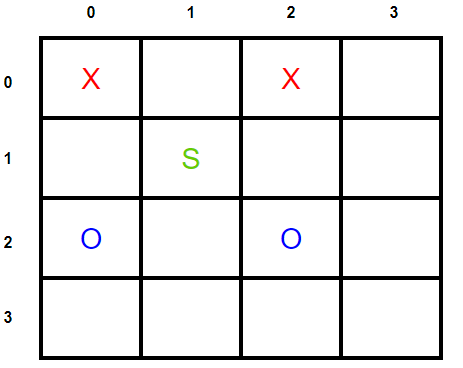

#Winning Move#
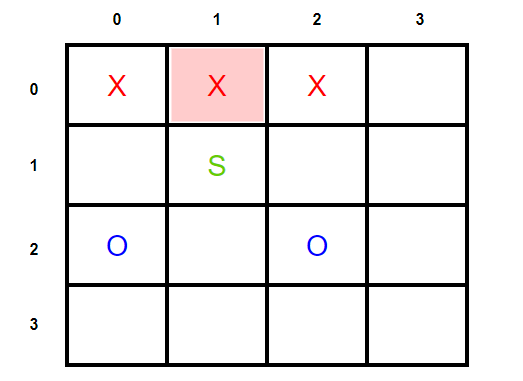

In [ ]:
# A board on which X can win - Play the move at [0, 1]
game = TicTacToeGame(4)
current_state = game.create_game_state(neutral_moves=[(1, 1),], 
                                       players_moves=[(X, 0, 0), (O, 2, 0),
                                                      (X, 0, 2), (O, 2, 2)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 
0 |X|_|X|_|
1 |_|S|_|_|
2 |O|_|O|_|
3 |_|_|_|_|

Turn: X



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	5417, 45, 60, 98, 50, 89, 56, 40, 45, 47, 52, 

Best move to make for X: (0, 1)

Resultant State:
   0 1 2 3 
0 |X|X|X|_|
1 |_|S|_|_|
2 |O|_|O|_|
3 |_|_|_|_|

Number of rollouts on this state (out of a total of 6000 rollouts): 5417



## Example 4: 5x5 Ex 1
This example features a 5x5 board with only two moves having been made. It is X's turn to play and the best move to make is the one that will maximise its future moves.

In [ ]:
game = TicTacToeGame(5)
current_state = game.create_game_state(neutral_moves=[(1, 4), (3, 0)], 
                                       players_moves=[(X, 2, 2), (O, 3, 3)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 4 
0 |_|_|_|_|_|
1 |_|_|_|_|S|
2 |_|_|X|_|_|
3 |S|_|_|O|_|
4 |_|_|_|_|_|

Turn: X



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	369, 265, 219, 394, 278, 238, 268, 1138, 954, 513, 803, 544, 566, 861, 810, 637, 281, 261, 227, 192, 181, 

Best move to make for X: (1, 2)

Resultant State:
   0 1 2 3 4 
0 |_|_|_|_|_|
1 |_|_|X|_|S|
2 |_|_|X|_|_|
3 |S|_|_|O|_|
4 |_|_|_|_|_|

Number of rollouts on this state (out of a total of 10000 rollouts): 1138



#Example 5: 5x5 Ex 2#
This example features a 5x5 board with a clear winning oppotunity for X. The best move in this regard is for X to play its token at row 1 column 4. 

#Initial State#
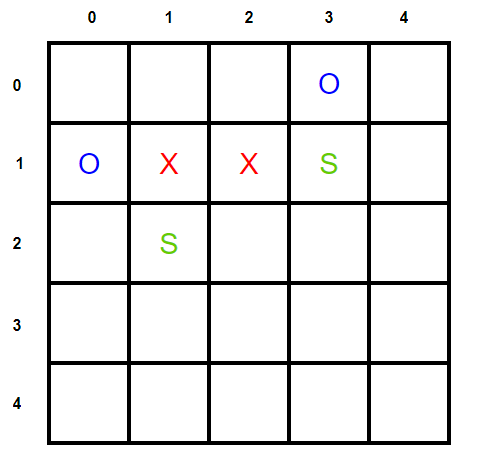

#Winning Move#
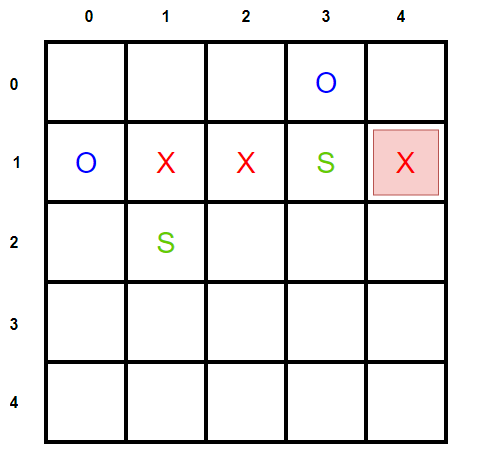

In [ ]:
# Winning board for X - Play at [1, 4]
game = TicTacToeGame(5)
current_state = game.create_game_state(neutral_moves=[(2, 1), (1, 3)], 
                                       players_moves=[(X, 1, 1), (O, 0, 3),
                                                      (X, 1, 2), (O, 1, 0)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 4 
0 |_|_|_|O|_|
1 |O|X|X|S|_|
2 |_|S|_|_|_|
3 |_|_|_|_|_|
4 |_|_|_|_|_|

Turn: X



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	118, 147, 157, 187, 6616, 187, 217, 299, 70, 189, 412, 161, 264, 115, 144, 177, 152, 213, 174, 

Best move to make for X: (1, 4)

Resultant State:
   0 1 2 3 4 
0 |_|_|_|O|_|
1 |O|X|X|S|X|
2 |_|S|_|_|_|
3 |_|_|_|_|_|
4 |_|_|_|_|_|

Number of rollouts on this state (out of a total of 10000 rollouts): 6616



## Example 6: 6x6 Ex 1
This example features a 6x6 board on which four moves have been made. The current state of the game is such that all the placed tokens are along the main diagonal. The ideal move for X would be to place its token strategically so that for its future turns, it has a better oppotuninty of winning as compared to O. 

In [ ]:
game = TicTacToeGame(6)
current_state =game.create_game_state(neutral_moves=[(1, 1), (4, 4)], 
                                      players_moves=[(X, 0, 0), (O, 2, 2), 
                                                    (X, 3, 3), (O, 5, 5)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 4 5 
0 |X|_|_|_|_|_|
1 |_|S|_|_|_|_|
2 |_|_|O|_|_|_|
3 |_|_|_|X|_|_|
4 |_|_|_|_|S|_|
5 |_|_|_|_|_|O|

Turn: X



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	445, 597, 508, 290, 307, 551, 775, 1381, 588, 266, 585, 1426, 1273, 957, 466, 472, 2956, 1463, 1596, 451, 335, 717, 1748, 2374, 241, 185, 276, 416, 578, 276, 

Best move to make for X: (3, 1)

Resultant State:
   0 1 2 3 4 5 
0 |X|_|_|_|_|_|
1 |_|S|_|_|_|_|
2 |_|_|O|_|_|_|
3 |_|X|_|X|_|_|
4 |_|_|_|_|S|_|
5 |_|_|_|_|_|O|

Number of rollouts on this state (out of a total of 24500 rollouts): 2956



#Example 7: 6x6 Ex 2#

#Initial State#
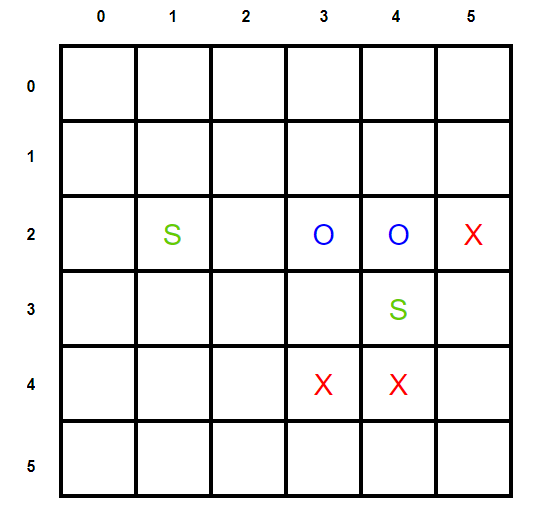

# Winning Move#
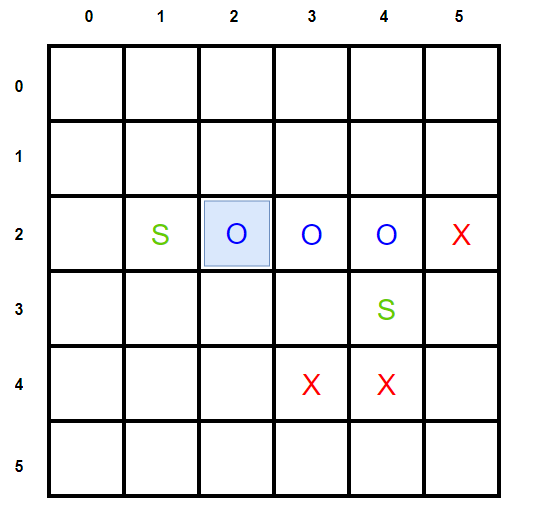

In [ ]:
# Winning board for O - Play at [2, 2]
game = TicTacToeGame(6)
current_state = game.create_game_state(neutral_moves=[(2, 1), (3, 4)], 
                                       players_moves=[(X, 2, 5), (O, 2, 3),
                                                      (X, 4, 3), (O, 2, 4),
                                                      (X, 4, 4)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 4 5 
0 |_|_|_|_|_|_|
1 |_|_|_|_|_|_|
2 |_|S|_|O|O|X|
3 |_|_|_|_|S|_|
4 |_|_|_|X|X|_|
5 |_|_|_|_|_|_|

Turn: O



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	2147, 354, 676, 795, 320, 1273, 1040, 727, 281, 941, 387, 1066, 1175, 71, 814, 579, 399, 460, 781, 1417, 511, 379, 390, 1424, 1082, 1238, 1328, 1062, 1382, 

Best move to make for O: (0, 0)

Resultant State:
   0 1 2 3 4 5 
0 |O|_|_|_|_|_|
1 |_|_|_|_|_|_|
2 |_|S|_|O|O|X|
3 |_|_|_|_|S|_|
4 |_|_|_|X|X|_|
5 |_|_|_|_|_|_|

Number of rollouts on this state (out of a total of 24500 rollouts): 2147



## Example 8: 7x7 Ex 1
This example features a 7x7 board. Due to its large board size and lack of moves made, there are plenty oppotunities for placing the next token strategically. 

In [ ]:
game = TicTacToeGame(7)
current_state = game.create_game_state(neutral_moves=[(2,2), (3, 5), (6, 1)], 
                                       players_moves=[(X, 6, 2), (O, 1, 3), 
                                                     (X, 3, 4)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 4 5 6 
0 |_|_|_|_|_|_|_|
1 |_|_|_|O|_|_|_|
2 |_|_|S|_|_|_|_|
3 |_|_|_|_|X|S|_|
4 |_|_|_|_|_|_|_|
5 |_|_|_|_|_|_|_|
6 |_|S|X|_|_|_|_|

Turn: O



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	831, 1513, 613, 1503, 587, 736, 991, 889, 573, 479, 628, 605, 1105, 776, 820, 573, 367, 449, 705, 1173, 523, 386, 424, 776, 538, 761, 519, 793, 567, 608, 542, 985, 775, 1139, 656, 676, 543, 958, 1257, 479, 579, 740, 859, 

Best move to make for O: (0, 1)

Resultant State:
   0 1 2 3 4 5 6 
0 |_|O|_|_|_|_|_|
1 |_|_|_|O|_|_|_|
2 |_|_|S|_|_|_|_|
3 |_|_|_|_|X|S|_|
4 |_|_|_|_|_|_|_|
5 |_|_|_|_|_|_|_|
6 |_|S|X|_|_|_|_|

Number of rollouts on this state (out of a total of 32000 rollouts): 1513



## Example 9: 7x7 Ex 2

In [ ]:
game = TicTacToeGame(7)
current_state = game.create_game_state(neutral_moves=[(2, 2), (4, 5), (6, 1)], 
                                       players_moves=[(X, 1, 2), (O, 1, 3), 
                                                     (X, 3, 1), (O, 2,0), 
                                                     (X, 3, 4)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 4 5 6 
0 |_|_|_|_|_|_|_|
1 |_|_|X|O|_|_|_|
2 |O|_|S|_|_|_|_|
3 |_|X|_|_|X|_|_|
4 |_|_|_|_|_|S|_|
5 |_|_|_|_|_|_|_|
6 |_|S|_|_|_|_|_|

Turn: O



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	1406, 656, 775, 859, 881, 1087, 805, 846, 857, 1183, 800, 1090, 635, 274, 454, 780, 1231, 678, 620, 493, 483, 1317, 922, 875, 690, 539, 394, 599, 1001, 1141, 632, 693, 876, 571, 768, 687, 509, 666, 574, 693, 959, 

Best move to make for O: (0, 0)

Resultant State:
   0 1 2 3 4 5 6 
0 |O|_|_|_|_|_|_|
1 |_|_|X|O|_|_|_|
2 |O|_|S|_|_|_|_|
3 |_|X|_|_|X|_|_|
4 |_|_|_|_|_|S|_|
5 |_|_|_|_|_|_|_|
6 |_|S|_|_|_|_|_|

Number of rollouts on this state (out of a total of 32000 rollouts): 1406



#Example 10: 7x7 Ex 3#
This example features a 7x7 board with a clear oppotunity ofr X to win. The penultimate move was made by O, where O has tried to stop X from winning. However, there is still a cell that X may make a move in to win the game.

#Initial State#
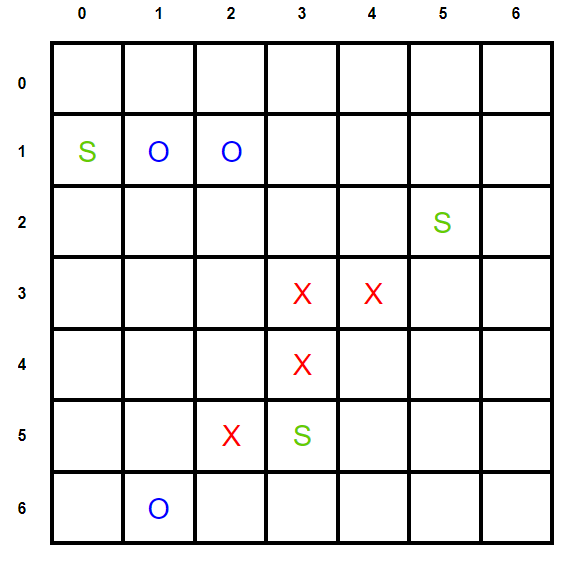

#Winning Move#
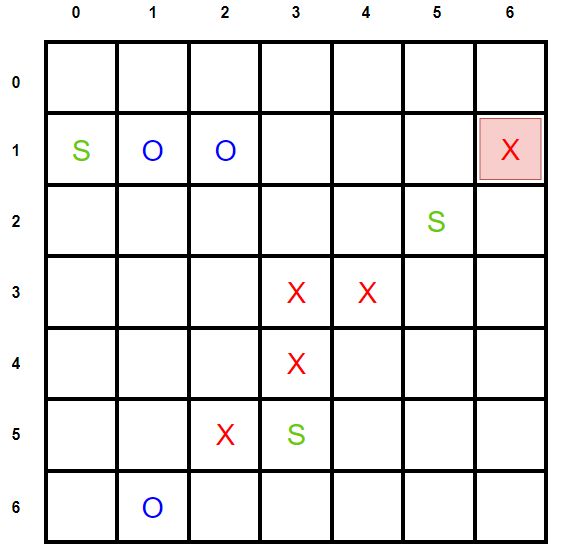

In [ ]:
# A Game state that requires one move to win - X should play at [1, 6]
game = TicTacToeGame(7)
current_state = game.create_game_state(neutral_moves=[(1, 0), (2, 5), (5, 3)], 
                                       players_moves=[(X, 5, 2), (O, 1, 1), 
                                                     (X, 4, 3), (O, 1, 2), 
                                                     (X, 3, 3), (O, 3, 2),
                                                      (X, 3, 4), (O, 6, 1)])

player = current_state.turn_to_string()                                       
print("\nCurrent State of the game:\n")
game.display_state(current_state)
print("\nTurn:", player)
print()


Current State of the game:

   0 1 2 3 4 5 6 
0 |_|_|_|_|_|_|_|
1 |S|O|O|_|_|_|_|
2 |_|_|_|_|_|S|_|
3 |_|_|O|X|X|_|_|
4 |_|_|_|X|_|_|_|
5 |_|_|X|S|_|_|_|
6 |_|O|_|_|_|_|_|

Turn: X



In [ ]:
print("Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state")
print("================================================================================================")

num_iterations = get_num_iterations(game)
best_move, resultant_state, max_rollouts = monte_carlo_tree_search(game, current_state, num_iterations)
print("Best move to make for ", player, ": ", best_move,  sep="")
print("\nResultant State:")
game.display_state(resultant_state)
print("\nNumber of rollouts on this state (out of a total of", num_iterations, "rollouts):", max_rollouts)

print("")

Running the Monte Carlo Tree Search Algorithm to find the best move to make on the current state
Number of rollouts on chidren of root node (representing current state of the game):
	154, 163, 305, 285, 217, 204, 209, 458, 426, 233, 22272, 196, 218, 394, 666, 261, 297, 204, 226, 229, 148, 254, 163, 295, 195, 273, 222, 191, 191, 475, 239, 231, 181, 181, 344, 252, 225, 322, 

Best move to make for X: (1, 6)

Resultant State:
   0 1 2 3 4 5 6 
0 |_|_|_|_|_|_|_|
1 |S|O|O|_|_|_|X|
2 |_|_|_|_|_|S|_|
3 |_|_|O|X|X|_|_|
4 |_|_|_|X|_|_|_|
5 |_|_|X|S|_|_|_|
6 |_|O|_|_|_|_|_|

Number of rollouts on this state (out of a total of 32000 rollouts): 22272



User input (we dont need this)



In [ ]:
"""
# Dimension of the board from user
try:
  size = int(input("Enter the size of the square board (4,5,6,7): "))

  if size < 4 or size > 7:
    size = 4 # Default if invalid value entered
except ValueError:
  size = 4 # Default if invalid (non-int) input

# Create game instance
ttt_game = TicTacToeGame(size)


# Create an initial state - No X's or O's are present

initial_state = ttt_game.create_game_state()

next_state = ttt_game.get_child_states(initial_state)
new_state = next_state[5]
move = [2,1]
next_state = ttt_game.play_move(new_state,move)

ttt_game.display_state(next_state)


best_move, resultant_state = monte_carlo_tree_search(ttt_game, next_state, 100)
"""